[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1qj2CSyA7pDwFm5svqU9uEWXC-e6lgLh1?usp=sharing)

# Push keras models to Huggingface hub

- https://huggingface.co/login
- https://huggingface.co/docs/hub/oauth
- https://huggingface.co/models

In [1]:
%%capture
! pip install git+https://github.com/huggingface/huggingface_hub.git@main
! sudo apt -qq install git-lfs
! git config --global credential.helper store

## Make sure you're logged in to Hugging Face CLI

In [2]:
! huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Simple Example

### Functional API

In [37]:
import tensorflow as tf
import keras
from keras import layers
from huggingface_hub import push_to_hub_keras

inputs = keras.Input(shape=(8, ), name='input_layer')
l_1 = layers.Dense(4, activation='relu', name='layer_1')(inputs)
l_2 = layers.Dense(4, activation='relu', name='layer_2')(l_1)
outputs = layers.Dense(1, name='output_layer')(l_2)

model = keras.Model(inputs=inputs, outputs=outputs, name='example_model')
model.summary()
model.build((None, 8))
push_to_hub_keras(model, 'keras-dummy-functional-demo')

Model: "example_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 8)]               0         
                                                                 
 layer_1 (Dense)             (None, 4)                 36        
                                                                 
 layer_2 (Dense)             (None, 4)                 20        
                                                                 
 output_layer (Dense)        (None, 1)                 5         
                                                                 
Total params: 61 (244.00 Byte)
Trainable params: 61 (244.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


saved_model.pb:   0%|          | 0.00/56.0k [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/aromo17/keras-dummy-functional-demo/commit/ff48a138fbaa78feacaaef5e828e0e08657bf0dc', commit_message='Push Keras model using huggingface_hub.', commit_description='', oid='ff48a138fbaa78feacaaef5e828e0e08657bf0dc', pr_url=None, pr_revision=None, pr_num=None)

## Load from pretrained model hub

In [7]:
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("keras-io/mobile-vit-xxs")
model.summary()
push_to_hub_keras(model, 'keras-mobile-vit-xxs')

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 256, 256, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv2d_84 (Conv2D)          (None, 128, 128, 16)         448       ['rescaling_3[0][0]']         
                                                                                                  
 conv2d_85 (Conv2D)          (None, 128, 128, 32)         512       ['conv2d_84[0][0]']           
                                                                                            

fingerprint.pb:   0%|          | 0.00/55.0 [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/382k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/3.69M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

variables.data-00000-of-00001:   0%|          | 0.00/5.41M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aromo17/keras-mobile-vit-xxs/commit/bd3dada59561cca05ae8c6036826fca3c43f7035', commit_message='Push Keras model using huggingface_hub.', commit_description='', oid='bd3dada59561cca05ae8c6036826fca3c43f7035', pr_url=None, pr_revision=None, pr_num=None)

# Complete Example

This is a more complete example of training a denoising autoencoder (taken from [keras-io/examples](https://github.com/keras-team/keras-io/blob/master/examples/vision/autoencoder.py))

In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [20]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## Prepare the data

11490434/11490434 [==============================] - 0s 0us/step


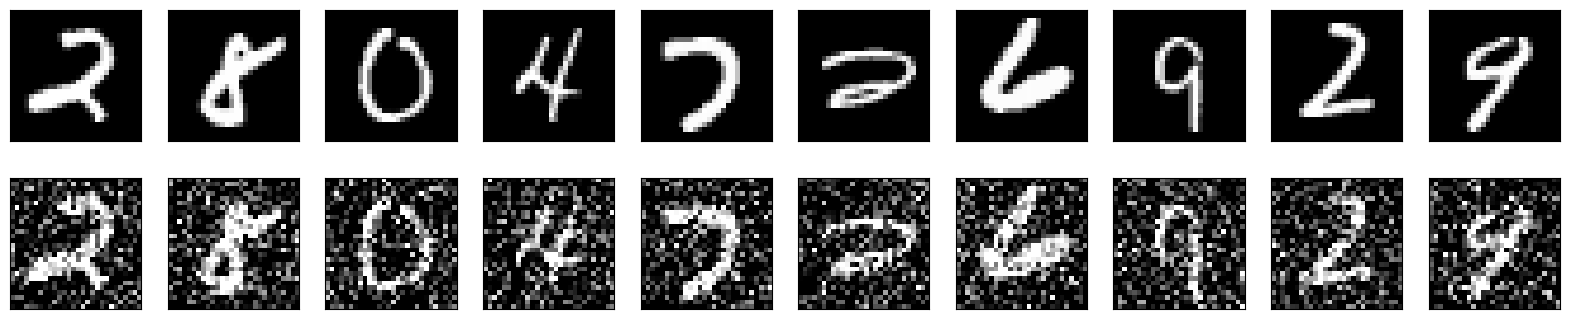

In [21]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

## Build the Autoencoder

We are going to use the Functional API to build our convolutional autoencoder.

In [ ]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 32)        9248

## Train the Autoencoder on Noisy Data

We want our autoencoder to learn how to denoise the images.

In [ ]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=3,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/3
469/469 [==============================] - 127s 271ms/step - loss: 0.0939 - val_loss: 0.0921
Epoch 2/3
469/469 [==============================] - 125s 267ms/step - loss: 0.0925 - val_loss: 0.0918
Epoch 3/3
469/469 [==============================] - 125s 267ms/step - loss: 0.0914 - val_loss: 0.0902


## Make Predictions

Let's now predict on the noisy data and display the results of our autoencoder.
Notice how the autoencoder does an amazing job at removing the noise from the
input images.

313/313 [==============================] - 7s 22ms/step


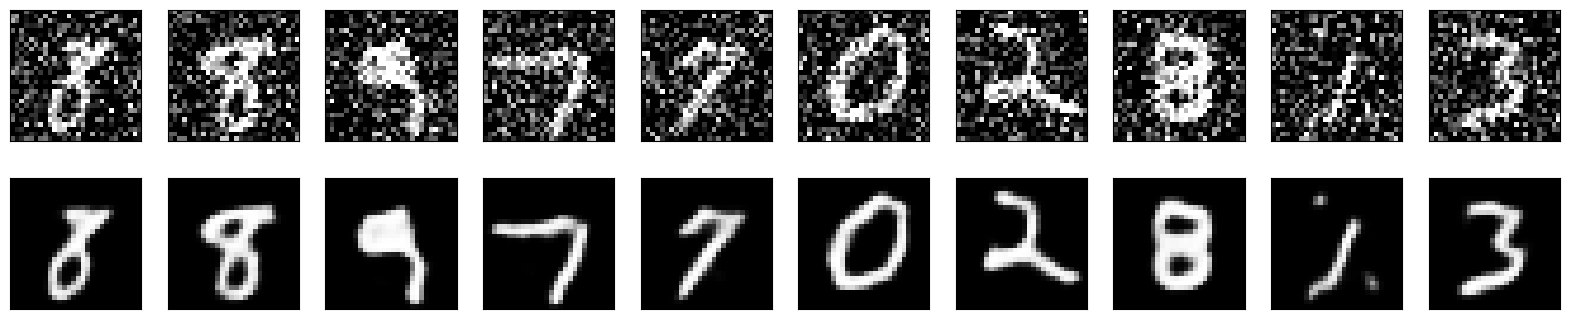

In [ ]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

## Push Autoencoder to Hugging Face Hub

In [ ]:
from huggingface_hub import push_to_hub_keras

push_to_hub_keras(autoencoder, 'autoencoder-keras-mnist-demo')

fingerprint.pb:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

saved_model.pb:   0%|          | 0.00/120k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aromo17/autoencoder-keras-mnist-demo/commit/723a2694f48355c7183a014467237f5ea3aeeb97', commit_message='Push Keras model using huggingface_hub.', commit_description='', oid='723a2694f48355c7183a014467237f5ea3aeeb97', pr_url=None, pr_revision=None, pr_num=None)

## Reload from hub and make predictions!

In [24]:
def display_image(image, title='Image'):
    plt.figure()
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

(28, 28, 1)

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

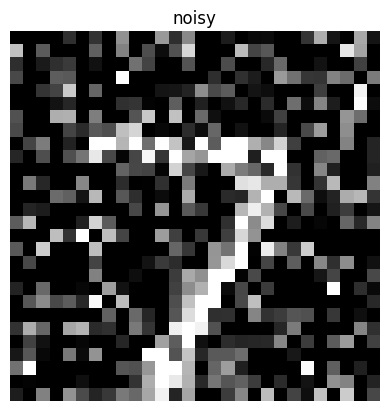

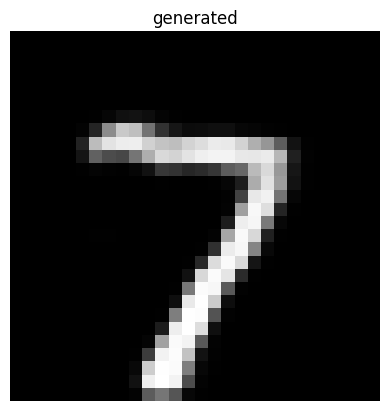

In [35]:
reloaded_model = from_pretrained_keras('aromo17/autoencoder-keras-mnist-demo')
input_image = noisy_test_data[0]
pred = reloaded_model.keras_api([input_image])

display_image(input_image, title='noisy')
display_image(pred[0], title='generated')